In [1]:
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor
from econml.dml import CausalForestDML as CausalForest  # This is the one from Wager Athey 2017
from econml.cate_interpreter import SingleTreeCateInterpreter
import shap
from tkinter import *
from warnings import simplefilter
import yaml
import pickle

from functions.figure_plotting import FigurePlot as fp
from vae.data_cleaning import DataClean as dc
from vae.vae_torch import VAE
from gan.wgan_torch import Generator

%matplotlib inline

In [ ]:
sns.set_theme()
sns.set_style("ticks")

#Avant Garde palette
CB91_Brown = "#7d5a1b"
CB91_Brown_Gray = "#816b51"
CB91_Green = "#294013"
CB91_Light_Green = "#d8ffc4"
CB91_Red = "#84290d"

# Out of palette
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Yellow = "#dfc077"

Green_Grad = ["#d8ffc4", "#bbdfa7", "#9ebf89", "#81a06c", "#63804e", "#466031", 
              "#294013", "#24380f", "#1e310b", "#192908", "#132204", "#0e1a00"]

Red_Grad = ["#fff1e3", "#efc6b0", "#df9b7d", "#cf6f4a", "#bf4417", "#ab3b14",
            "#983210", "#84290d", "#70200a", "#5c1707", "#490e03", "#350500"]

Brown_Grad = ["#fffac3", "#efda9d", "#dfc077", "#cfa550",  "#bf8b2a", "#a97a24", 
              "#93681e", "#7d5718", "#684512", "#52340c", "#3c2206", "#261100"]

color_list = [CB91_Brown, CB91_Green, CB91_Light_Green, CB91_Red,
              CB91_Purple, CB91_Violet,  CB91_Yellow, CB91_Brown_Gray]

#A list of hex colours running between blue and purple
CB91_Grad_BP = ['#2cbdfe', '#2fb9fc', '#33b4fa', '#36b0f8',
                '#3aacf6', '#3da8f4', '#41a3f2', '#449ff0',
                '#489bee', '#4b97ec', '#4f92ea', '#528ee8',
                '#568ae6', '#5986e4', '#5c81e2', '#607de0',
                '#6379de', '#6775dc', '#6a70da', '#6e6cd8',
                '#7168d7', '#7564d5', '#785fd3', '#7c5bd1',
                '#7f57cf', '#8353cd', '#864ecb', '#894ac9',
                '#8d46c7', '#9042c5', '#943dc3', '#9739c1',
                '#9b35bf', '#9e31bd', '#a22cbb', '#a528b9',
                '#a924b7', '#ac20b5', '#b01bb3', '#b317b1']

sns.set(font="Verdana",
        rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False})
 
custom_colors = color_list
sns.set_palette(sns.color_palette(color_list, 8))

sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

In [2]:
np.random.seed(42)
torch.manual_seed(42)
simplefilter(action='ignore', category=FutureWarning)

In [3]:
preprocessing_configuration_file = "configurations/categorical_preprocessing_configuration.yaml"
# data_filename = "data/FI_2013p_EUSILC.csv"   # Original data
data_filename = "data/original_preprocessed.csv"  # Pre-imputed file
plotting_configuration_file = "configurations/print.yaml"
draw = fp(plotting_configuration_file)

In [4]:
# EU-SILC Finland
begin = time.time()
data_original = pd.read_csv(data_filename)
data = dc(datafile=data_filename,
          prepared=True,
          configuration_file=preprocessing_configuration_file
          )
duration = time.time() - begin
print(duration)

Using provided preprocessed file data/original_preprocessed.csv
0.27174997329711914


In [5]:
df = data.get_data()

In [6]:
feature_dimension = df.shape[1]

# Set up pretrained wgan-gp and vae models

Pytorch wgan-gp with Adam 300 iters for all variables (230) with following scores:
* RSME 0.072
* Pearson's 0.999
* R2 0.999

Alternative wgan-gp model with same setting as above + one-category per variable removed (199) with following scores:
* RSME 0.128
* Pearson's 0.997
* R2 0.996

VAE model from Keras:



In [7]:
model_configuration_file = "configurations/causal.yaml"

In [8]:
with open(model_configuration_file, 'r') as file:
    cfg = yaml.safe_load(file)
causal_cfg = cfg["model"]
name = cfg["globals"]["name"]
model_name = cfg["globals"]["model_name"][0]
model_type = cfg["globals"]["model_type"]

In [9]:
# Variables to load pretrained vae and wgan models (torch)
latent_gan = int(causal_cfg["latent_gan"])
latent_vae = int(causal_cfg["latent_vae"])
beta_1 = float(causal_cfg["beta1"])
beta_2 = float(causal_cfg["beta2"])
learning_rate_gan = float(causal_cfg["lr_gan"])
learning_rate_vae = float(causal_cfg["lr_vae"])

In [10]:
# Load WGAN-GP
wgan_dict = torch.load(causal_cfg["generator_dict_file"])
wgan_opt_dict = torch.load(causal_cfg["opt_gen_dict_file"])
generator_gan = Generator(feature_dimension, latent_gan)
opt_wgan = optim.Adam(generator_gan.parameters(), lr=learning_rate_gan, betas=(beta_1, beta_2))
generator_gan.load_state_dict(wgan_dict)
opt_wgan.load_state_dict(wgan_opt_dict)

In [11]:
# Load VAE
vae_dict = torch.load(causal_cfg["vae_dict_file"])
opt_vae_dict = torch.load(causal_cfg["opt_vae_dict_file"])
model_vae = VAE(feature_dimension, latent_vae)
opt_vae = optim.RMSprop(model_vae.parameters(), lr=learning_rate_vae)
model_vae.load_state_dict(vae_dict)
opt_vae.load_state_dict(opt_vae_dict)

In [12]:
# Use best Torch WGAN-GP (is working)
# generator_gan = torch.jit.load('models/wgan/gp-generator_lr_0.0001_epochs_250_c-iter_5_leaky_02__output_dim_1__feature_dim_230_optimiser_Adam.pt')
# generator_gan.eval()

In [13]:
# Use beste Torch beta-VAE
# model_vae = torch.jit.load('models/vae/betavae_lr_0.0001_epochs_80_batch_91_leaky_02__beta_0.5_feature_dim_230_optimiser_RMSprop.pt')
# model_vae.eval()

In [14]:
# Generate WGAN-data from randomised fake
fake_gan = torch.randn(df.shape[0], latent_gan)
tf_synthetic_gan = generator_gan(fake_gan)

In [15]:
fake_vae = torch.randn([df.shape[0], latent_vae])
tf_synthetic_vae = model_vae.decoder(fake_vae)

# Check if trained models produce expected data

If correlation plots do not correspond to the trained metrics, the model loaded is not properly pretrained.

In [16]:
df_o = data.get_data()

In [17]:
noise = torch.randn(df.shape[0], latent_gan)
tf_gan = generator_gan(noise)
df_s_gan = data.get_synthetic(tf_gan.detach().numpy())

get_synthetic() no columns
Do detect 11 difference!!!
Old data shape (19291, 219)
New dataframe shape (19291, 11)
Returned dataframe has shape (19291, 230)


In [18]:
fake = torch.randn([df.shape[0], latent_vae])
tf_vae = model_vae.decoder(fake)
df_s_vae = data.get_synthetic(tf_vae.detach().numpy())

get_synthetic() no columns
Do detect 29 difference!!!
Old data shape (19291, 201)
New dataframe shape (19291, 29)
Returned dataframe has shape (19291, 230)


In [19]:
combine_wgan = pd.concat([df_o.mean(), df_s_gan.mean()], axis=1)
combine_wgan.columns = ["original", "WGAN"]

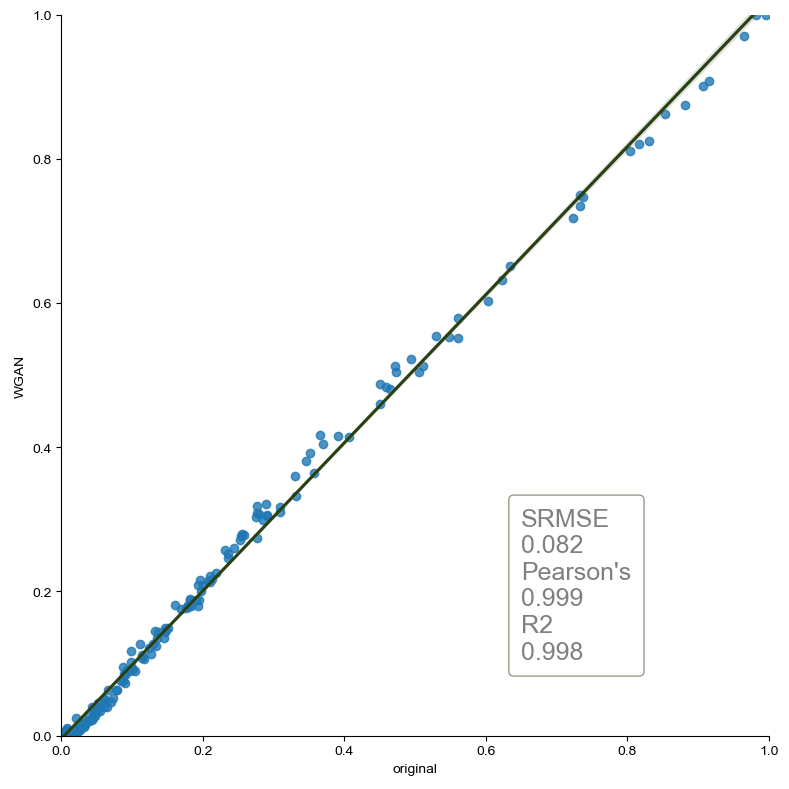

In [20]:
draw.plot_compare(data=combine_wgan,
                  title="compare-wgan",
                  model_type="categorical",
                  model="WGAN_GP",
                  model_name=str(latent_gan),
                  #save=True
                  )

In [21]:
combine_vae = pd.concat([df_o.mean(), df_s_vae.mean()], axis=1)
combine_vae.columns = ["original", "VAE"]

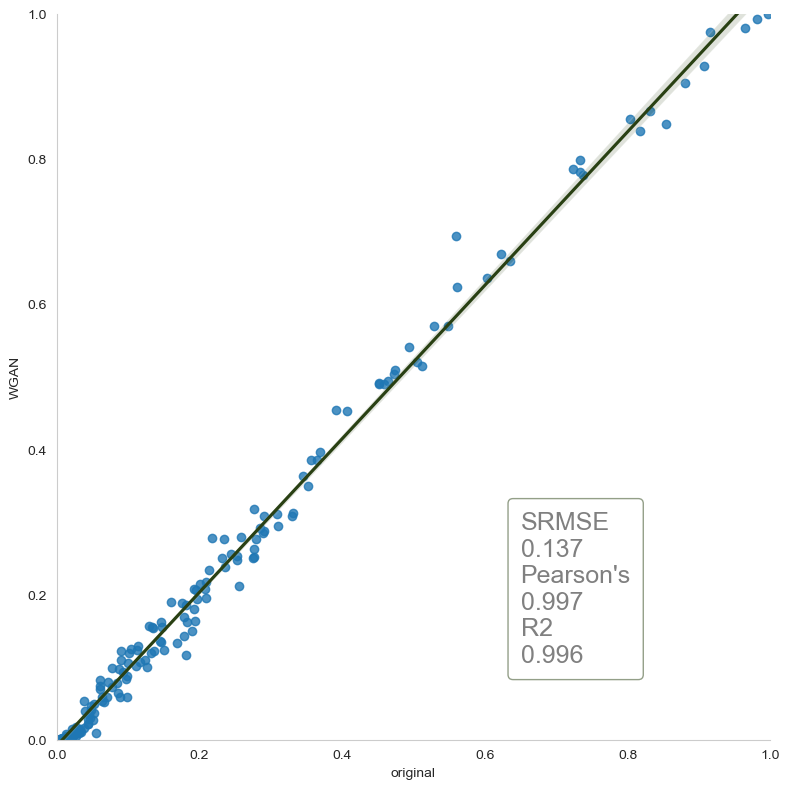

In [22]:
draw.plot_compare(data=combine_vae,
                  title="compare-vae",
                  model_type="categorical",
                  model="VAE",
                  model_name=str(latent_vae),
                  #save=True
                  )

In [23]:
assert df_o.shape == df_s_vae.shape

In [24]:
assert df_o.shape == df_s_gan.shape

In [25]:
remove_one_hots = ["Age_5", "PB190_4", "PD020_3", "PD030_3", "PD050_2", "PD060_2",
                   "PD070_3", "PD080_2", "PH030_1", "PH040_1", "PH060_1", "PL031_9",
                   "PL040_4", "PW010_0", "PW020_0", "PW030_0", "PW040_0", "PW050_1",
                   "PW060_1", "PW070_5", "PW080_1", "PW090_5", "PW120_0", "PW130_10",
                   "PW140_1", "PW150_0", "PW160_0", "PW190_1", "PW210_4", "PW220_4",
                   "householdSize_5"]

remove_health = ["PH010_1", "PH010_2", "PH010_3", "PH010_4", "PH010_5"]
# FIRST RUN has all these variables:
# SECOND RUN (remove)
# PL031_6 = Pupil from education
# Age_1 (youngest = in edu) maybe also removed
remove_edu = ["PE040_2", "PE040_3", "PE040_4", "PE040_5", "PL031_6", "Age_1"]
remove_soc = ["PD050_1", "PD050_3"]
remove_lei = ["PD060_1", "PD060_3"]
remove_psy = ["PW050_2", "PW050_3", "PW050_4", "PW050_5"]

In [26]:
df_o_treatment = data.get_data()
df_s_treatment = data.get_synthetic(tf_synthetic_gan.detach().numpy())
df_sv_treatment = data.get_synthetic(tf_synthetic_vae.detach().numpy())
# Use the recategorised data version to set Outcome (PH010) and Treatment
# variables (PE040, PD050, PD060, PW050)
df_get_health = data.get_data_recategorised()
df_get_health_synthetic_gan = data.get_synthetic_recategorised(tf_synthetic_gan.detach().numpy())
df_get_health_synthetic_vae = data.get_synthetic_recategorised(tf_synthetic_vae.detach().numpy())

get_synthetic() no columns
Do detect 9 difference!!!
Old data shape (19291, 221)
New dataframe shape (19291, 9)
Returned dataframe has shape (19291, 230)
get_synthetic() no columns
Do detect 30 difference!!!
Old data shape (19291, 200)
New dataframe shape (19291, 30)
Returned dataframe has shape (19291, 230)
get_synthetic_recategorised() no columns
get_synthetic_recategorised() no columns


In [27]:
df_o_treatment["Health"] = np.where(df_get_health["PH010"] < 3, 1, 0)
df_s_treatment["Health"] = np.where(df_get_health_synthetic_gan["PH010"] < 3, 1, 0)
df_sv_treatment["Health"] = np.where(df_get_health_synthetic_vae["PH010"] < 3, 1, 0)

In [28]:
df_o_treatment["Edu_A"] = np.where(df_get_health["PE040"] < 3, 0, 1)
df_s_treatment["Edu_A"] = np.where(df_get_health_synthetic_gan["PE040"] < 3, 0, 1)
df_sv_treatment["Edu_A"] = np.where(df_get_health_synthetic_vae["PE040"] < 3, 0, 1)

In [29]:
df_o_treatment["Edu_B"] = np.where(df_get_health["PE040"] < 4, 0, 1)
df_s_treatment["Edu_B"] = np.where(df_get_health_synthetic_gan["PE040"] < 4, 0, 1)
df_sv_treatment["Edu_B"] = np.where(df_get_health_synthetic_vae["PE040"] < 4, 0, 1)

In [30]:
df_o_treatment["Soc"] = np.where(df_get_health["PD050"] < 2, 1, 0)
df_s_treatment["Soc"] = np.where(df_get_health_synthetic_gan["PD050"] < 2, 1, 0)
df_sv_treatment["Soc"] = np.where(df_get_health_synthetic_vae["PD050"] < 2, 1, 0)

In [31]:
df_o_treatment["Lei"] = np.where(df_get_health["PD060"] < 2, 1, 0)
df_s_treatment["Lei"] = np.where(df_get_health_synthetic_gan["PD060"] < 2, 1, 0)
df_sv_treatment["Lei"] = np.where(df_get_health_synthetic_vae["PD060"] < 2, 1, 0)

In [32]:
df_o_treatment["Psy"] = np.where(df_get_health["PW050"] < 4, 0, 1)
df_s_treatment["Psy"] = np.where(df_get_health_synthetic_gan["PW050"] < 4, 0, 1)
df_sv_treatment["Psy"] = np.where(df_get_health_synthetic_vae["PW050"] < 4, 0, 1)

In [33]:
df_o_treatment = df_o_treatment.drop(remove_one_hots, axis=1)
df_s_treatment = df_s_treatment.drop(remove_one_hots, axis=1)
df_sv_treatment = df_sv_treatment.drop(remove_one_hots, axis=1)

In [34]:
X_o = df_o_treatment.iloc[:,:-6].copy()
X_s = df_s_treatment.iloc[:,:-6].copy()
X_sv = df_sv_treatment.iloc[:,:-6].copy()
X_oo = X_o.drop(remove_health, axis=1)    # Original
X_ss = X_s.drop(remove_health, axis=1)    # WGAN
X_svv = X_sv.drop(remove_health, axis=1)  # VAE

In [35]:
health_model_edu_A = CausalForest(n_estimators=800,
                                  model_t=LogisticRegressionCV(solver='newton-cg',
                                                               max_iter=300),
                                  min_samples_leaf=5,
                                  random_state=42,
                                  discrete_treatment=True,
                                  inference=True,
                                  max_depth=8,
                                  criterion="het",
                                  cv=10)

health_model_edu_B = CausalForest(n_estimators=800,
                                  model_t=LogisticRegressionCV(solver='newton-cg', 
                                                               max_iter=300),
                                  min_samples_leaf=5,
                                  random_state=42,
                                  discrete_treatment=True,
                                  inference=True,
                                  max_depth=8,
                                  criterion="het",
                                  cv=10)

health_model_soc = CausalForest(n_estimators=800,
                                model_t=LogisticRegressionCV(solver='newton-cg', 
                                                             max_iter=300),
                                min_samples_leaf=5,   # Try 2000
                                random_state=42,
                                discrete_treatment=True,
                                inference=True,
                                max_depth=8,
                                criterion="het",
                                cv=10)

health_model_lei = CausalForest(n_estimators=800,
                                model_t=LogisticRegressionCV(solver='newton-cg', 
                                                             max_iter=300),
                                min_samples_leaf=5,
                                random_state=42,
                                inference=True,
                                max_depth=8,
                                criterion="het",
                                cv=10)

health_model_psy = CausalForest(n_estimators=800,
                                model_t=LogisticRegressionCV(solver='newton-cg', 
                                                             max_iter=300),
                                min_samples_leaf=5,
                                random_state=42,
                                discrete_treatment=True,
                                inference=True,
                                max_depth=8,
                                criterion="het",
                                cv=10)

# Treatment Education

Running two versions:
* Edu_A: 0 ----> PE040 = 0, 1, 2       1 ----> PE040 = 3, 4, 5
* Edu_B: 0 ----> PE040 = 0, 1, 2, 3    1 ----> PE040 = 4, 5

In [36]:
X_o = X_oo.copy()
X_o = X_o.drop(remove_edu, axis=1)
X_s = X_ss.copy()
X_s = X_s.drop(remove_edu, axis=1)
X_sv = X_svv.copy()
X_sv = X_sv.drop(remove_edu, axis=1)

In [37]:
begin = time.time()
health_model_edu_A = health_model_edu_A.fit(Y=df_o_treatment["Health"], 
                                            X=X_o, 
                                            T=df_o_treatment["Edu_A"]
                                            )
duration = time.time() - begin
print(duration)

1327.1818540096283


In [38]:
# Save the trained Causal Forest model
# health_model_edu_A = pickle.load(open("models/CFDML_edu_A.pkl", 'rb'))
with open ("models/CFDML_edu_A_het.pkl", "wb") as f:
    pickle.dump(health_model_edu_A, f)

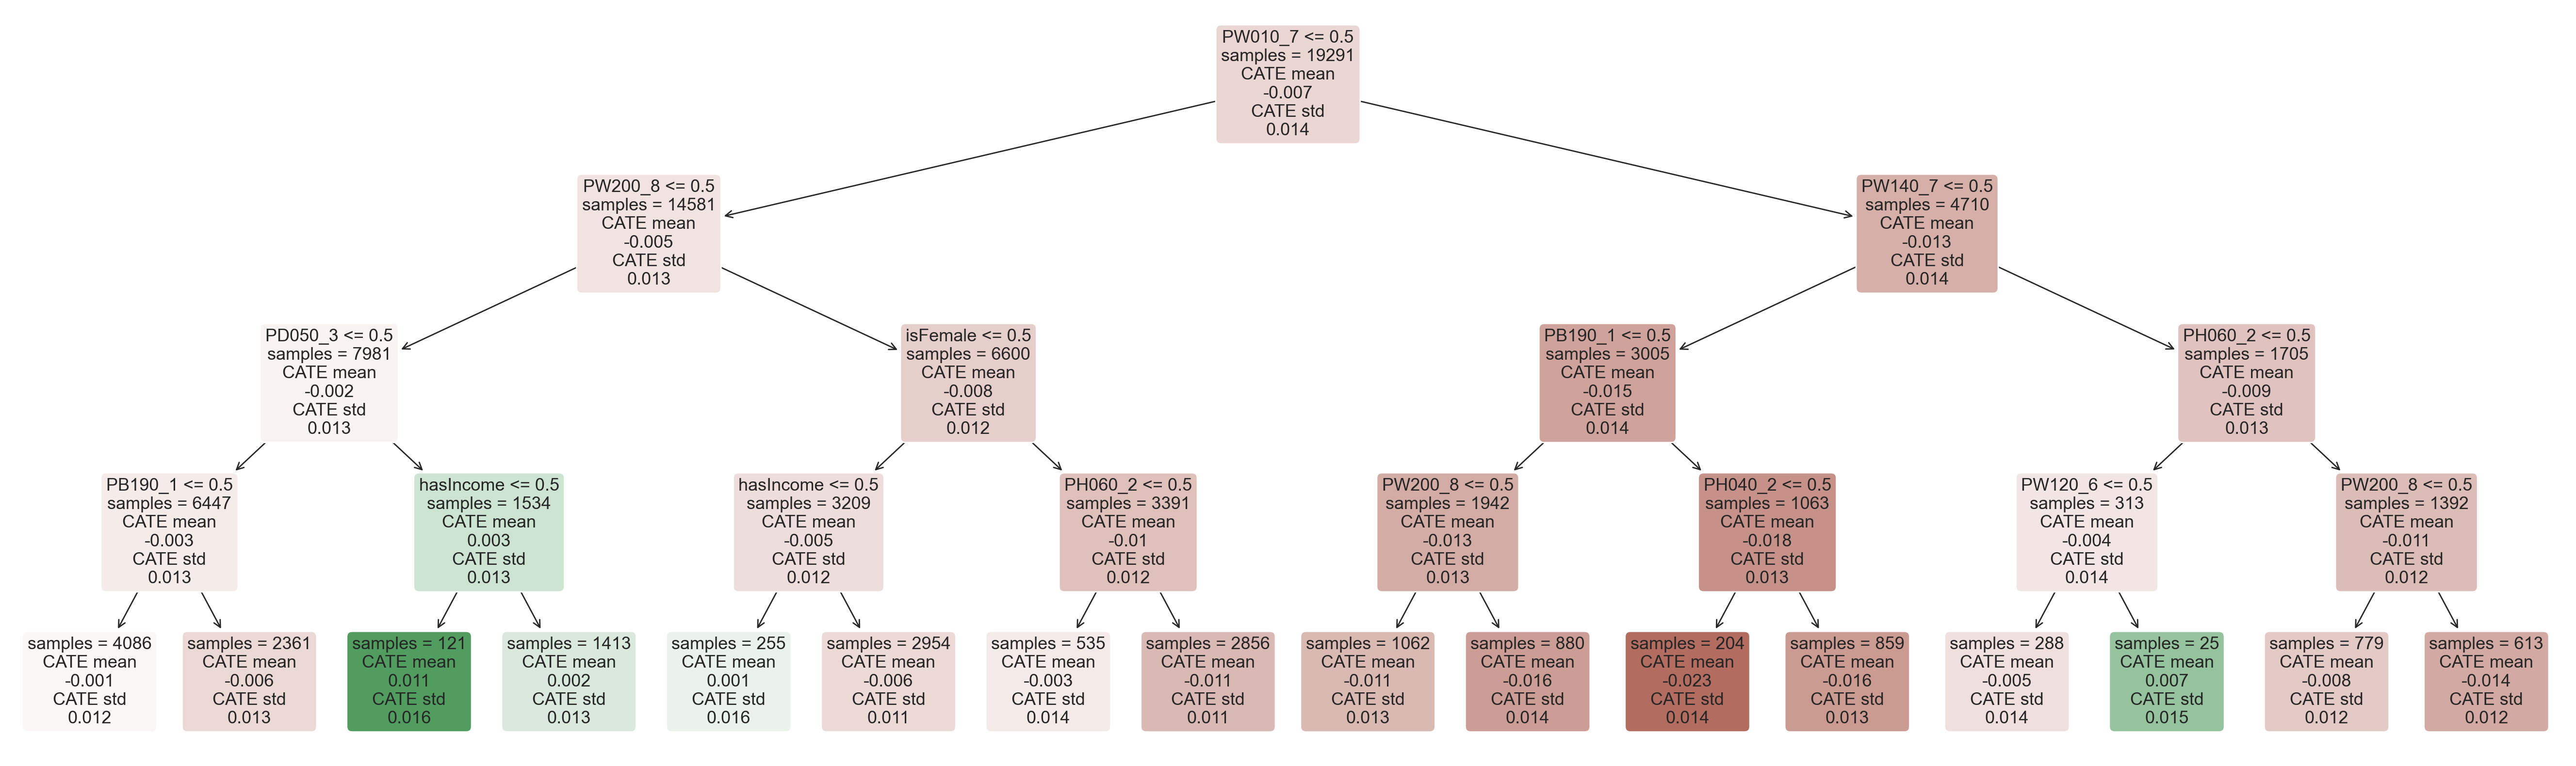

In [39]:
# Original
interprete_edu_A_o = SingleTreeCateInterpreter(max_depth=4).interpret(health_model_edu_A, X_o)
interprete_edu_A_o.plot(feature_names=X_o.columns, fontsize=13)
plt.gcf().set_size_inches(34, 10)
plt.gcf().set_dpi(200)

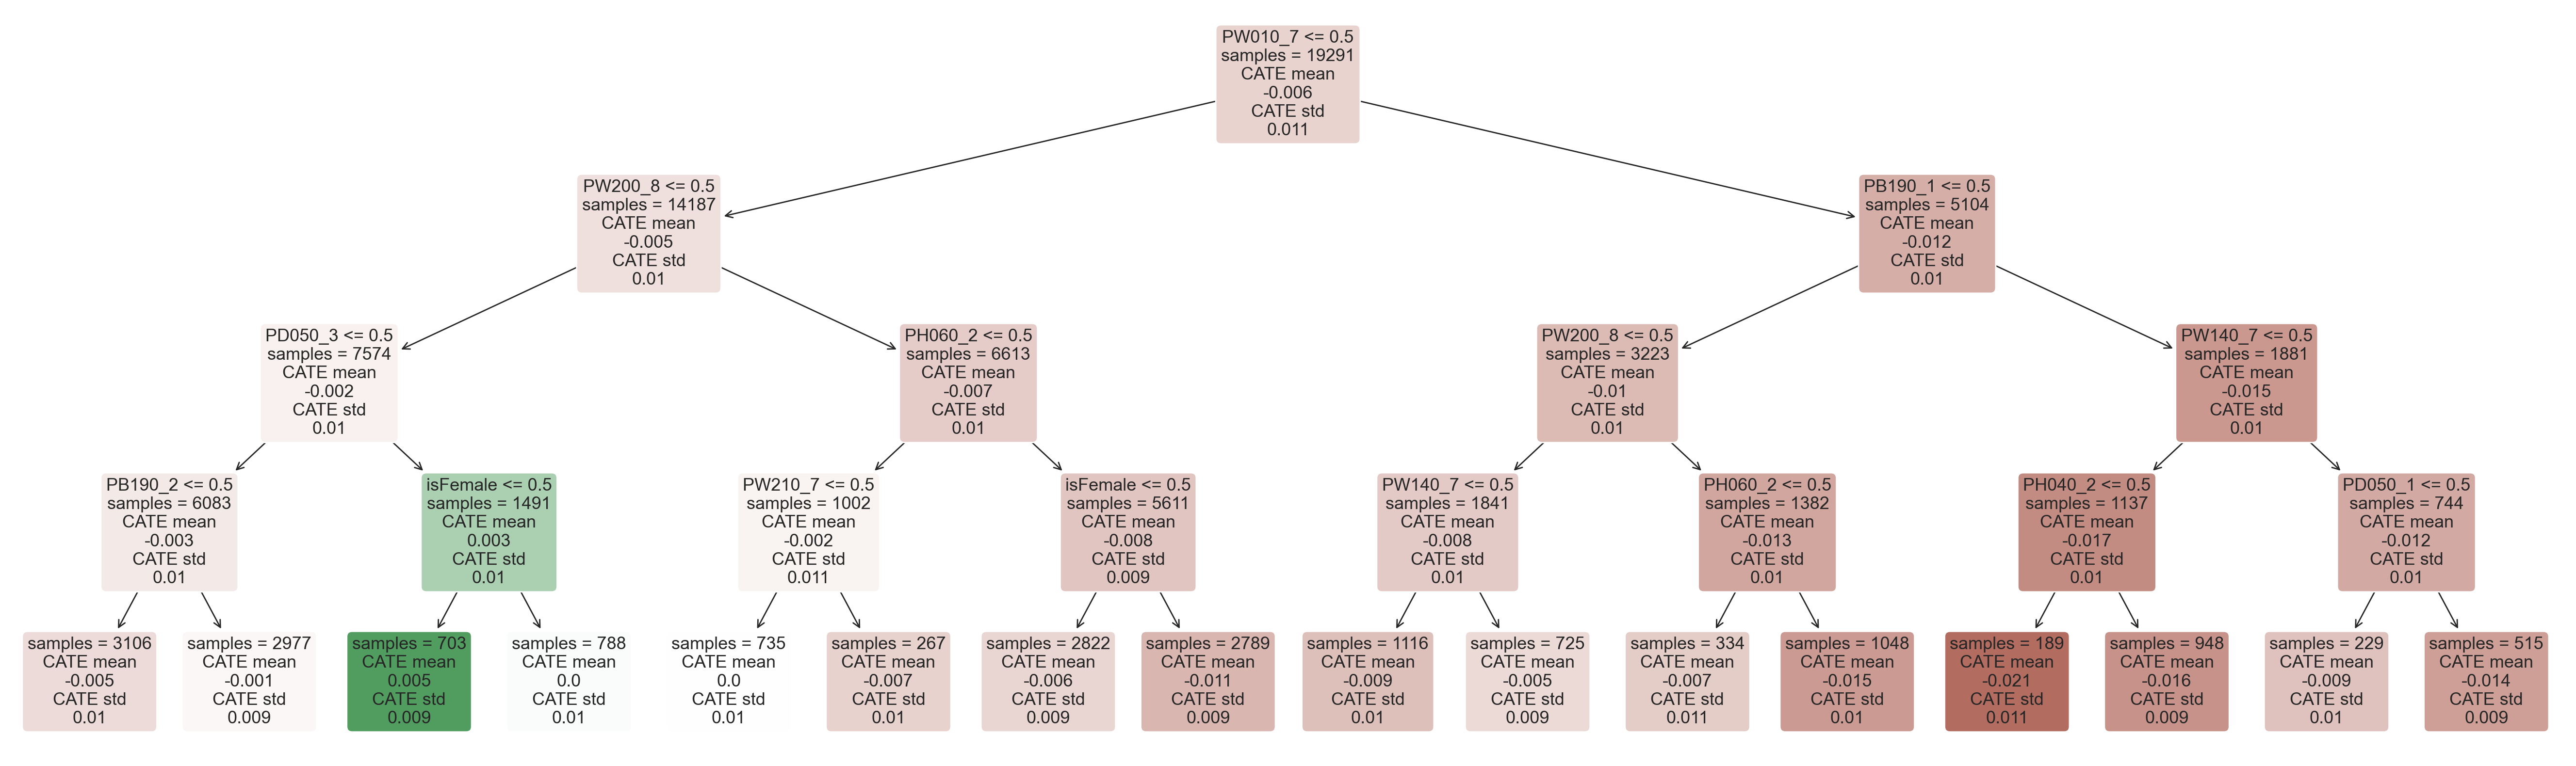

In [40]:
# WGAN
interprete_edu_A_s = SingleTreeCateInterpreter(max_depth=4).interpret(health_model_edu_A, X_s)
interprete_edu_A_s.plot(feature_names=X_s.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

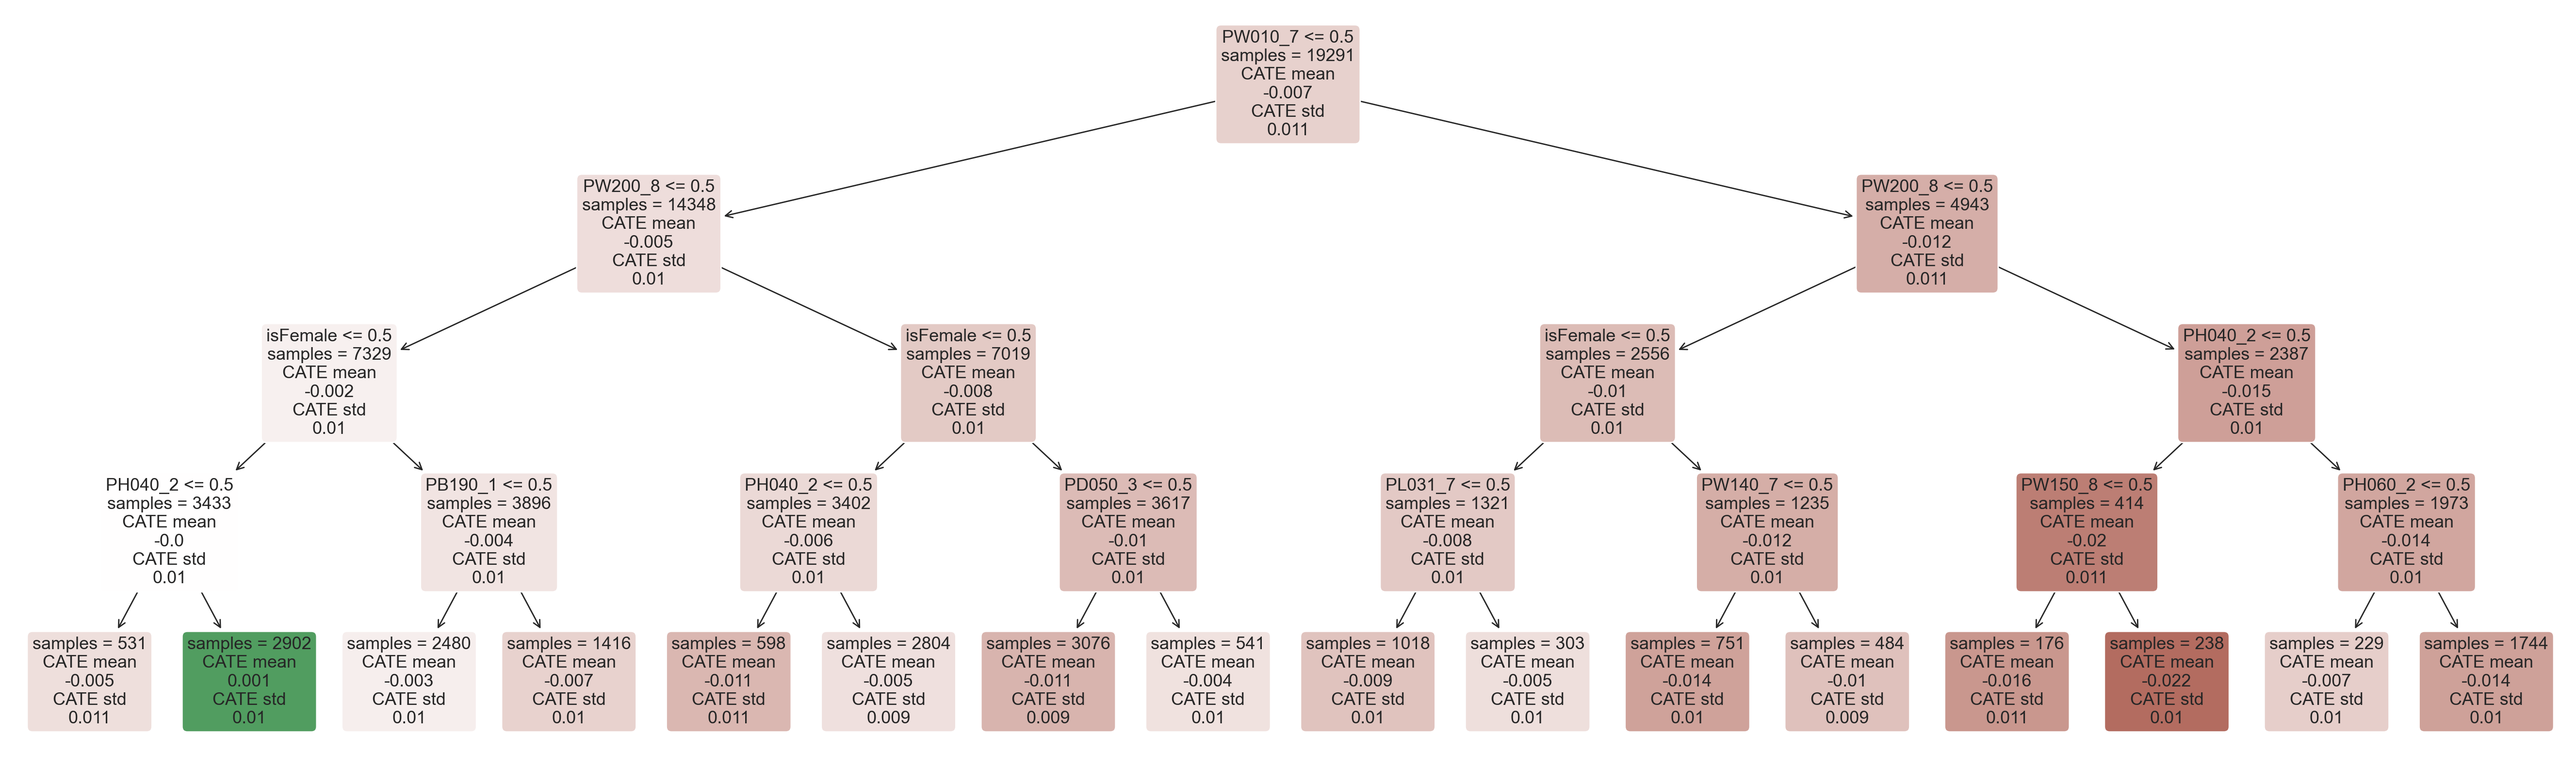

In [41]:
# VAE
interprete_edu_A_sv = SingleTreeCateInterpreter(max_depth=4).interpret(health_model_edu_A, X_sv)
interprete_edu_A_sv.plot(feature_names=X_sv.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

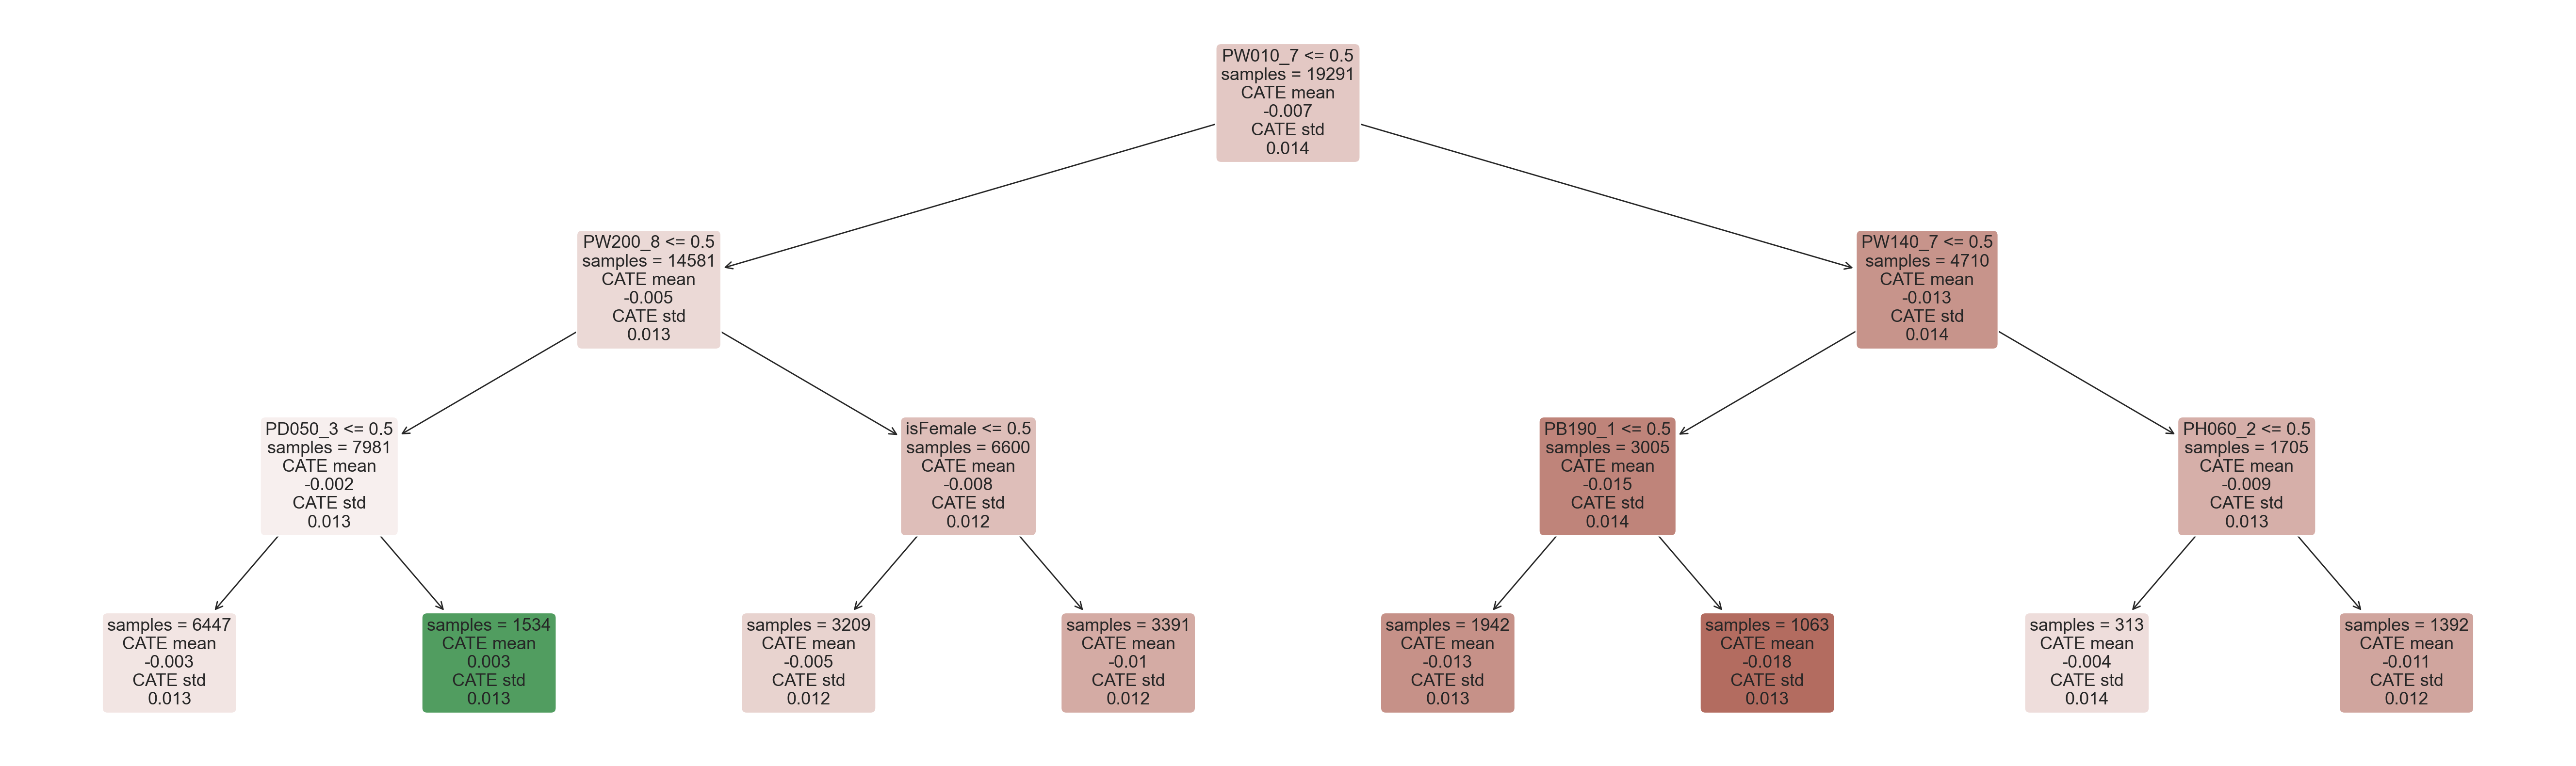

In [42]:
# Original
interprete_edu_A_o = SingleTreeCateInterpreter(max_depth=3).interpret(health_model_edu_A, X_o)
interprete_edu_A_o.plot(feature_names=X_o.columns, fontsize=13)
plt.gcf().set_size_inches(34, 10)
plt.gcf().set_dpi(200)

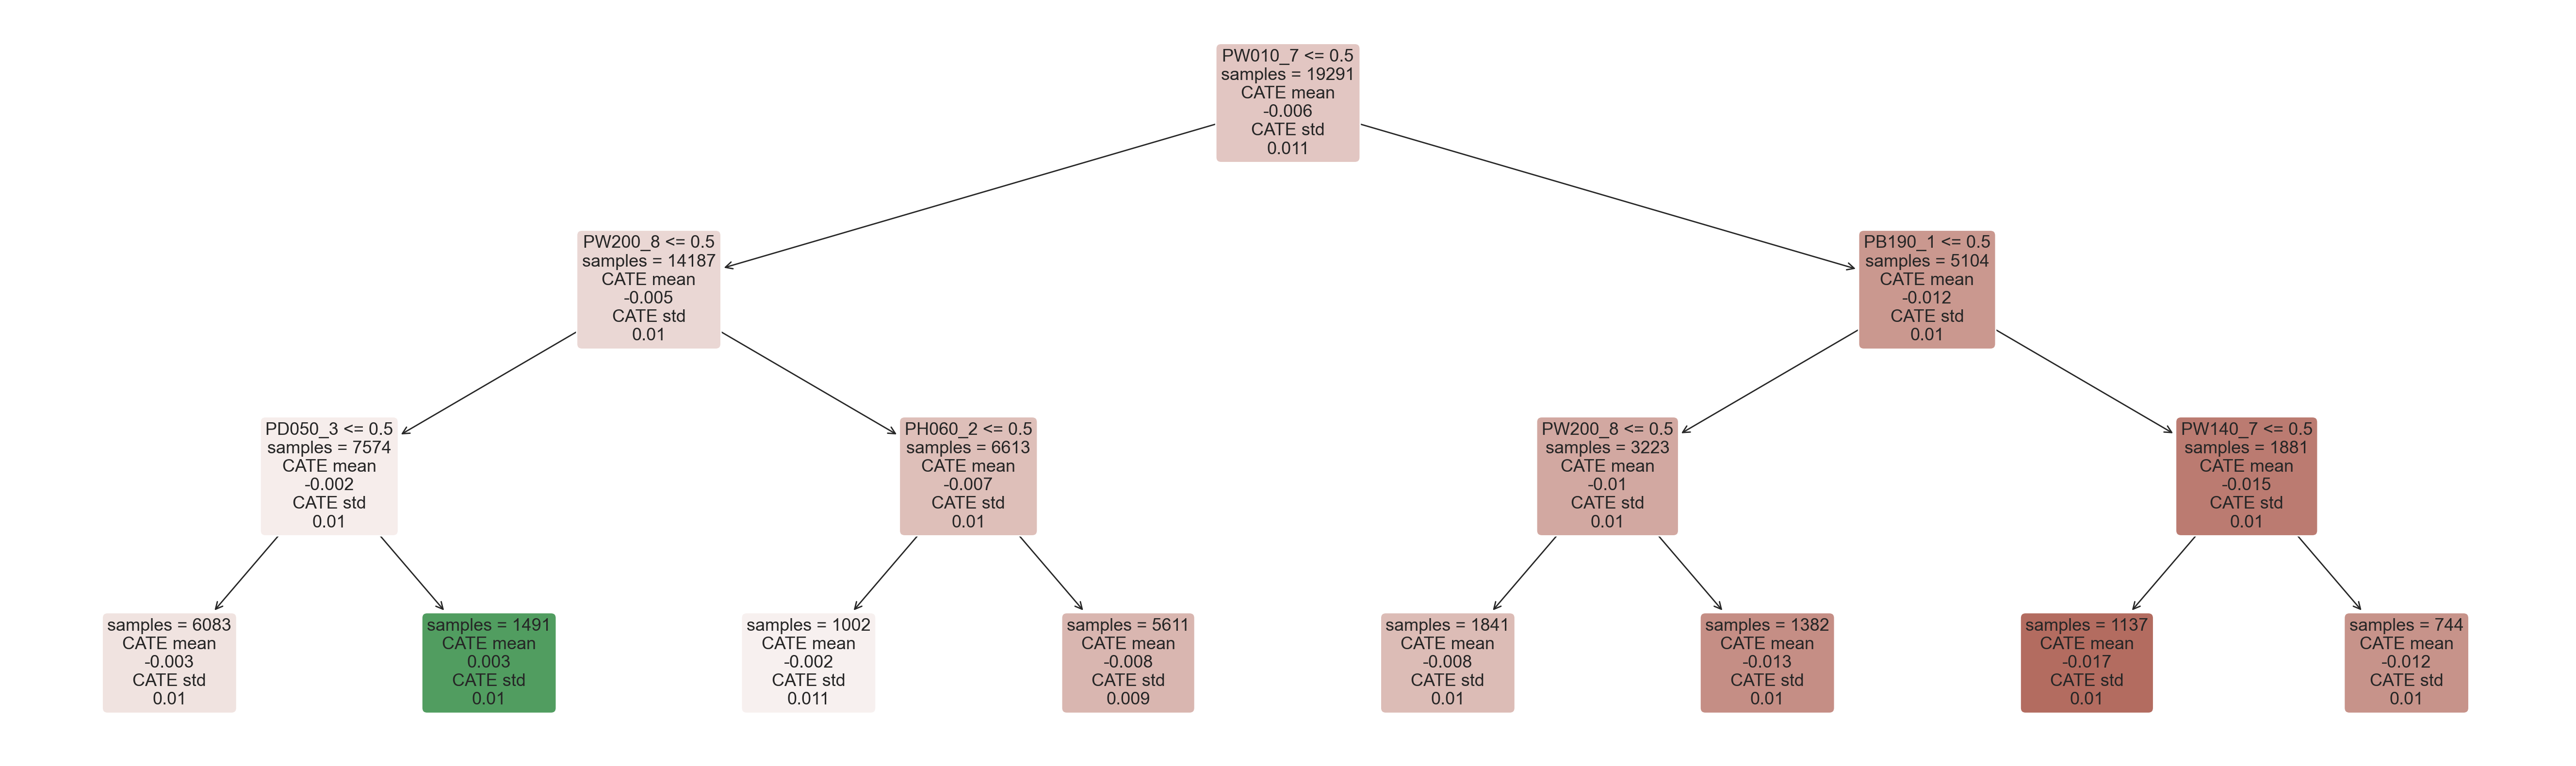

In [43]:
# WGAN
interprete_edu_A_s = SingleTreeCateInterpreter(max_depth=3).interpret(health_model_edu_A, X_s)
interprete_edu_A_s.plot(feature_names=X_s.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

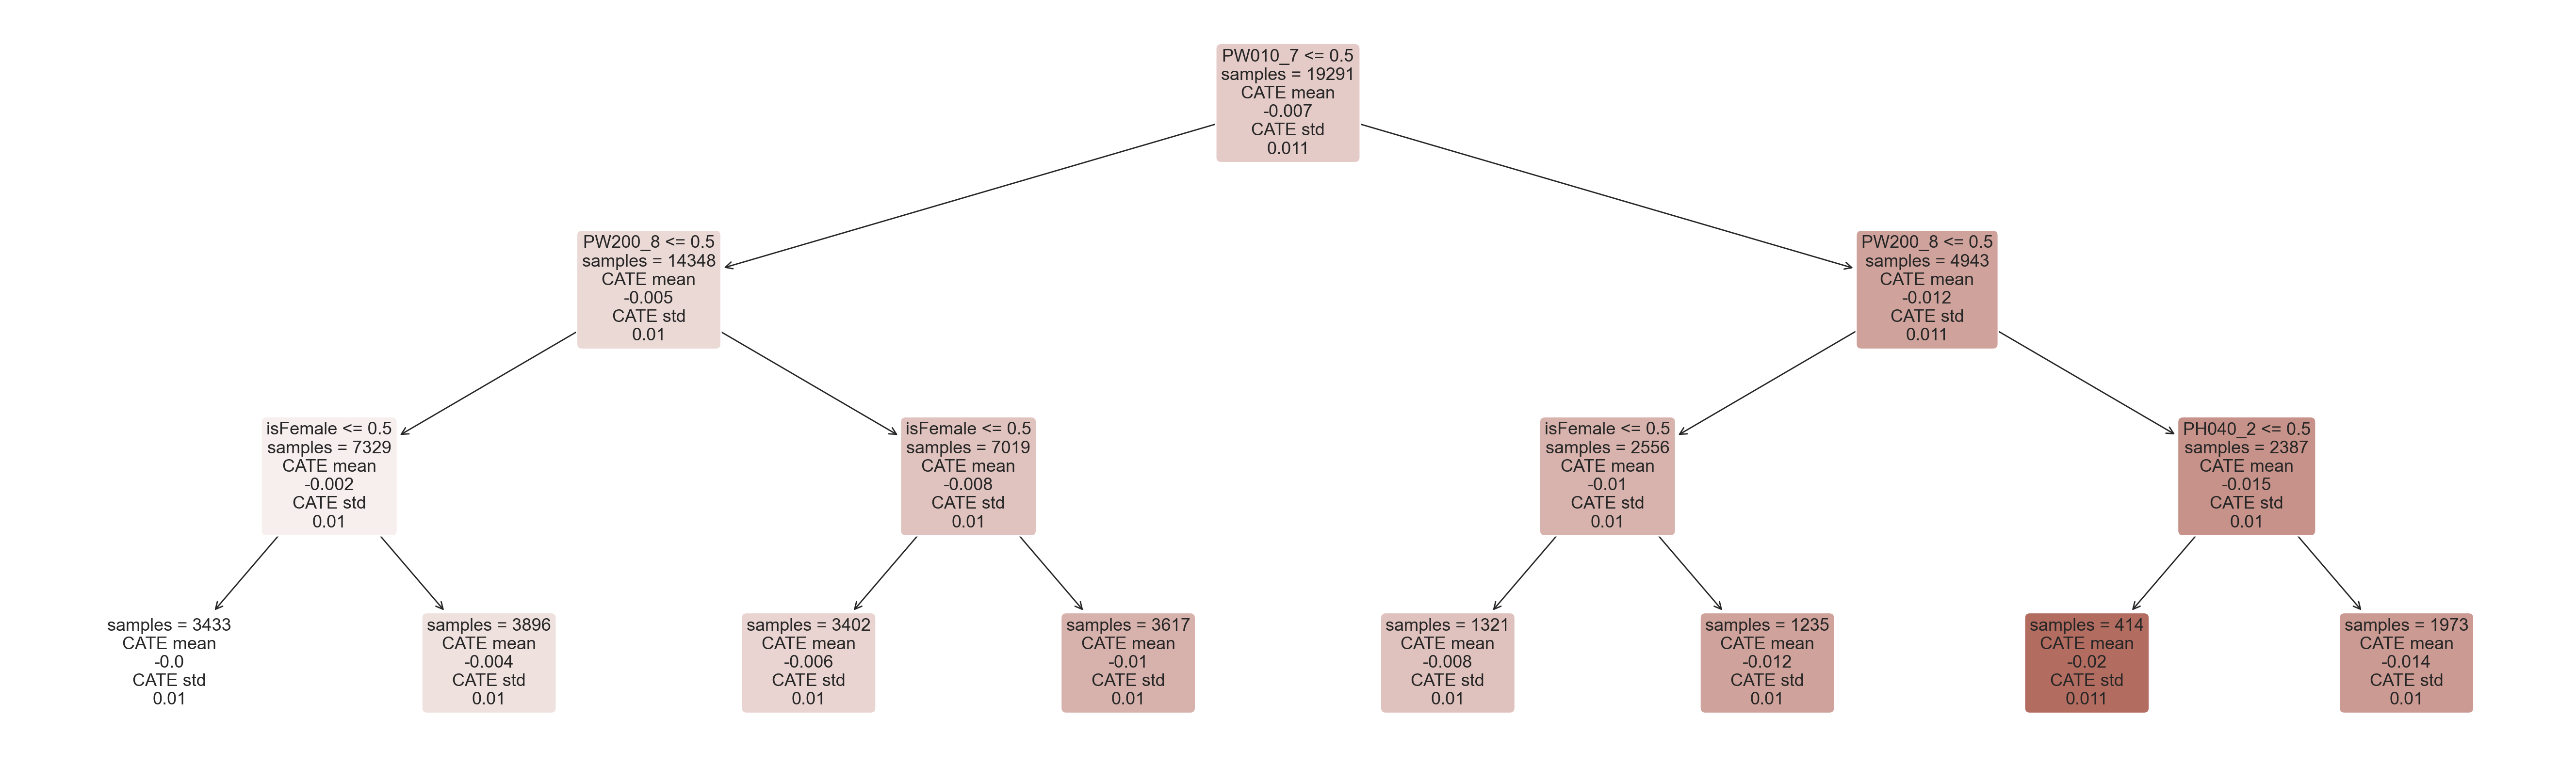

In [44]:
# VAE
interprete_edu_A_sv = SingleTreeCateInterpreter(max_depth=3).interpret(health_model_edu_A, X_sv)
interprete_edu_A_sv.plot(feature_names=X_sv.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [45]:
#shap_values_edu_A_o = health_model_edu_A.shap_values(X_o)

In [46]:
#shap_values_edu_A_s = health_model_edu_A.shap_values(X_s)

In [47]:
#shap_values_edu_A_sv = health_model_edu_A.shap_values(X_sv)

In [48]:
#expected_values = health_model_edu_A.effect(df_health.iloc[:,:-2])

In [49]:
# use causal forest model to estimate treatment effects  
treatment_effects = health_model_edu_A.effect(X_o)
# calculate lower bound and upper bound confidence intervals 
lb, ub = health_model_edu_A.effect_interval(X_o, alpha=0.05)

In [50]:
lb.shape

In [51]:
ub.shape

In [52]:
# convert arrays to pandas dataframes for plotting
te_df = pd.DataFrame(treatment_effects, columns=['cate'])
lb_df = pd.DataFrame(lb, columns=['lb'])
ub_df = pd.DataFrame(ub, columns=['ub'])

te_df.head()

cate
0 -0.007881
1  0.007370
2 -0.035202
3 -0.030593
4  0.006022

In [53]:
lb_df.head()

lb
0 -0.061356
1 -0.109352
2 -0.095299
3 -0.132467
4 -0.059991

In [54]:
ub_df.head()

ub
0  0.045595
1  0.124091
2  0.024895
3  0.071282
4  0.072035

In [55]:
# merge dataframes and sort 
#df = te_df.merge(lb_df, left_on=te_df.index, right_on=lb_df.index, how='left')
df = pd.concat([te_df, lb_df, ub_df], axis=1)
df.head()

cate        lb        ub
0 -0.007881 -0.061356  0.045595
1  0.007370 -0.109352  0.124091
2 -0.035202 -0.095299  0.024895
3 -0.030593 -0.132467  0.071282
4  0.006022 -0.059991  0.072035

In [56]:

#df.drop(columns=['key_0'], inplace=True)
#df = df.merge(ub_df, left_on=df.index, right_on=ub_df.index, how='left')
#df = pd.concat([ub_df, lb_df], axis=1)
#df = df.drop(['key_0'], axis=0)
df.sort_values('cate', inplace=True, ascending=True)
df.reset_index(inplace=True, drop=True)

# calculate rolling mean
z = df.rolling(window=30, center=True).mean()

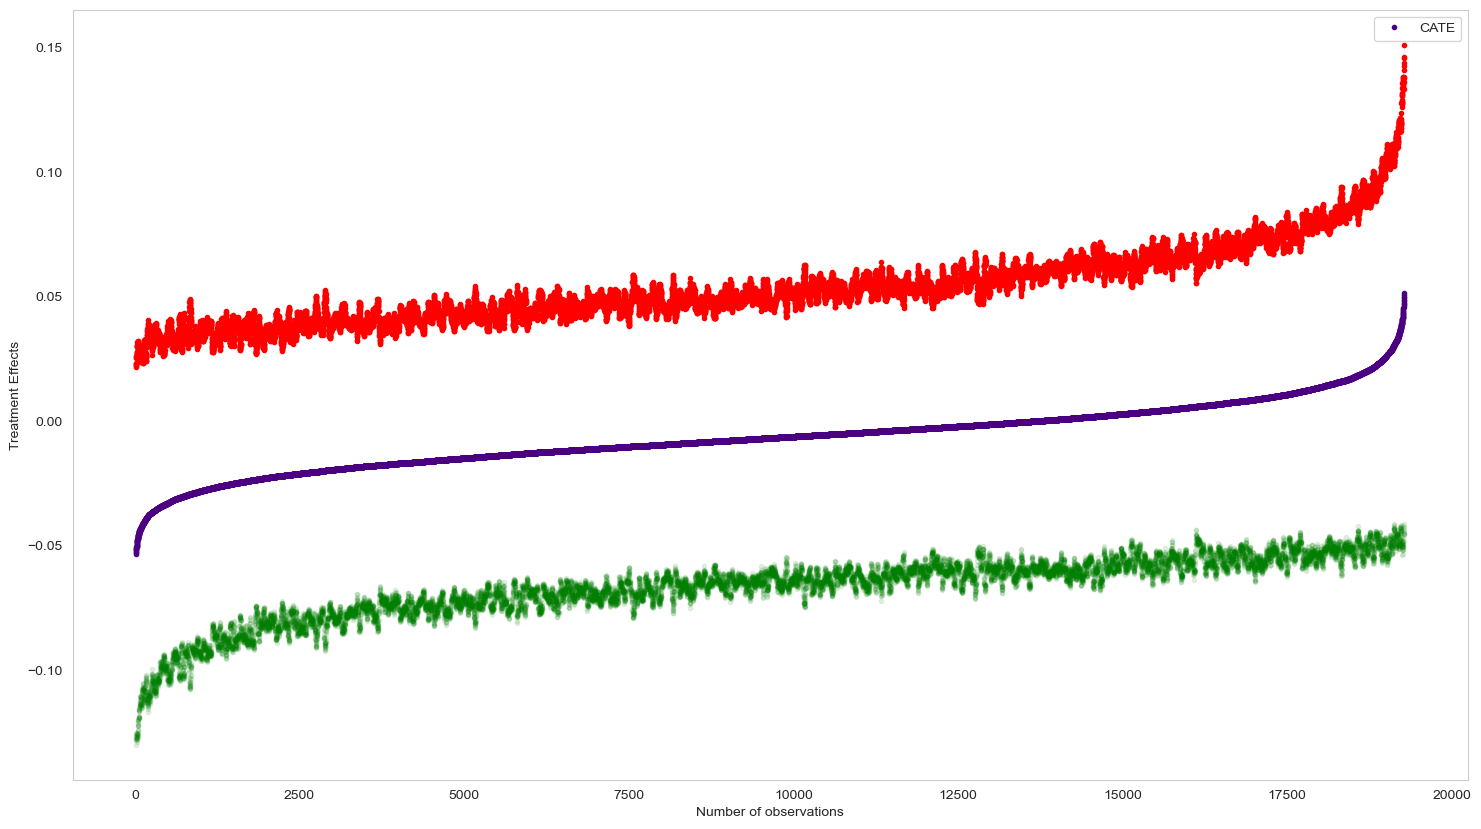

In [57]:
"""
Plot showing the treatment effect (Education) and confidence intervals for Finish population 2013
postulated by the causal forest model.

"""

# set plot size
fig, ax = plt.subplots(figsize=(18, 10))
# plot lines for treatment effects and confidence intervals
ax.plot(z['cate'],
        marker='.', linestyle='-', linewidth=0.01, label='CATE', color="indigo")
ax.plot(z['lb'],
        marker='.', linestyle='-', linewidth=0.1, color='green', alpha=0.1)
ax.plot(z['ub'],
        marker='.', linestyle='-', linewidth=0.1, color='red')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

In [ ]:
begin = time.time()
health_model_edu_B = health_model_edu_B.fit(Y=df_o_treatment["Health"], 
                                            X=X_o, 
                                            T=df_o_treatment["Edu_B"])
duration = time.time() - begin
print(duration)

In [ ]:
# Save the trained Causal Forest model
with open ("models/CFDML_edu_B_het.pkl", "wb") as f:
    pickle.dump(health_model_edu_B, f)

In [ ]:
# Original
intrprete_edu_B_o = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_edu_B_o.interpret(health_model_edu_B, X_o)
intrprete_edu_B_o.plot(feature_names=X_o.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# WGAN
intrprete_edu_B_s = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_edu_B_s.interpret(health_model_edu_B, X_s)
intrprete_edu_B_s.plot(feature_names=X_s.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# VAE
intrprete_edu_B_sv = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_edu_B_sv.interpret(health_model_edu_B, X_sv)
intrprete_edu_B_sv.plot(feature_names=X_sv.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# Original
intrprete_edu_B_o = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_edu_B_o.interpret(health_model_edu_B, X_o)
intrprete_edu_B_o.plot(feature_names=X_o.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# WGAN
intrprete_edu_B_s = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_edu_B_s.interpret(health_model_edu_B, X_s)
intrprete_edu_B_s.plot(feature_names=X_s.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# VAE
intrprete_edu_B_sv = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_edu_B_sv.interpret(health_model_edu_B, X_sv)
intrprete_edu_B_sv.plot(feature_names=X_sv.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
shap_values_edu_B_o = health_model_edu_B.shap_values(X_o)

In [ ]:
shap_values_edu_B_s = health_model_edu_B.shap_values(X_s)

In [ ]:
shap_values_edu_B_sv = health_model_edu_B.shap_values(X_sv)

In [ ]:
X_o = X_oo.copy()
X_o = X_o.drop(remove_soc, axis=1)
X_s = X_ss.copy()
X_s = X_s.drop(remove_soc, axis=1)
X_sv = X_svv.copy()
X_sv = X_sv.drop(remove_soc, axis=1)

In [ ]:
begin = time.time()
health_model_soc = health_model_soc.fit(Y=df_o_treatment["Health"], 
                                        X=X_o, 
                                        T=df_o_treatment["Soc"])
duration = time.time() - begin
print(duration)

In [ ]:
# Save the trained Causal Forest model
with open ("models/CFDML_soc_het.pkl", "wb") as f:
    pickle.dump(health_model_soc, f)

In [ ]:
intrprete_soc_o = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_soc_o.interpret(health_model_soc, X_o)
intrprete_soc_o.plot(feature_names=X_o.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
intrprete_soc_s = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_soc_s.interpret(health_model_soc, X_s)
intrprete_soc_s.plot(feature_names=X_s.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
intrprete_soc_sv = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_soc_sv.interpret(health_model_soc, X_sv)
intrprete_soc_sv.plot(feature_names=X_sv.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# Original
intrprete_soc_o = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_soc_o.interpret(health_model_soc, X_o)
intrprete_soc_o.plot(feature_names=X_o.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# WGAN
intrprete_soc_s = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_soc_s.interpret(health_model_soc, X_s)
intrprete_soc_s.plot(feature_names=X_s.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# VAE
intrprete_soc_sv = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_soc_sv.interpret(health_model_soc, X_sv)
intrprete_soc_sv.plot(feature_names=X_sv.columns, fontsize=13)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
shap_values_soc_o = health_model_soc.shap_values(X_o)

In [ ]:
shap_values_soc_s = health_model_soc.shap_values(X_s)

In [ ]:
shap_values_soc_sv = health_model_soc.shap_values(X_sv)

In [ ]:
draw.shap_summary(shap_values=shap_values_soc_o["Health"]["Soc_1"],
                  features=X_o,
                  title="orig_soc",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
draw.shap_summary(shap_values=shap_values_soc_s["Health"]["Soc_1"],
                  features=X_s,
                  title="gan_soc",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
draw.shap_summary(shap_values=shap_values_soc_sv["Health"]["Soc_1"],
                  features=X_sv,
                  title="vae_soc",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
shap.plots.bar(shap_values_soc_o["Health"]["Soc_1"], 
               max_display=10,
               show=False) # default is max_display=12
fig = plt.gcf() # gcf means "get current figure"
fig.set_figheight(6)
fig.set_figwidth(6)
#plt.rcParams['font.size'] = '12'
ax = plt.gca() #gca means "get current axes"
ax.title.set_text('Original Data')
plt.tight_layout()
plt.show()

In [ ]:
shap.plots.bar(shap_values_soc_s["Health"]["Soc_1"], 
               max_display=10,
               show=False) 
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)
ax = plt.gca()
ax.title.set_text('WGAN Data')
plt.tight_layout()
plt.show()

In [ ]:
shap.plots.bar(shap_values_soc_sv["Health"]["Soc_1"], 
               max_display=10,
               show=False) 
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)
ax = plt.gca()
ax.title.set_text('VAE Data')
plt.tight_layout()
plt.show()

In [ ]:
X_o = X_oo.copy()
X_o = X_o.drop(remove_lei, axis=1)
X_s = X_ss.copy()
X_s = X_s.drop(remove_lei, axis=1)
X_sv = X_svv.copy()
X_sv = X_sv.drop(remove_lei, axis=1)

In [ ]:
begin = time.time()
health_model_lei = health_model_lei.fit(Y=df_o_treatment["Health"],
                                        X=X_o,
                                        T=df_o_treatment["Lei"])
duration = time.time() - begin
print(duration)

In [ ]:
# Save the trained Causal Forest model
with open ("models/CFDML_lei_het.pkl", "wb") as f:
    pickle.dump(health_model_lei, f)

In [ ]:
# Original
intrprete_lei_o = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_lei_o.interpret(health_model_lei, X_o)
intrprete_lei_o.plot(feature_names=X_o.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# WGAN
intrprete_lei_s = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_lei_s.interpret(health_model_lei, X_s)
intrprete_lei_s.plot(feature_names=X_s.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# VAE
intrprete_lei_sv = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_lei_sv.interpret(health_model_lei, X_sv)
intrprete_lei_sv.plot(feature_names=X_sv.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# Original
intrprete_lei_o = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_lei_o.interpret(health_model_lei, X_o)
intrprete_lei_o.plot(feature_names=X_o.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# WGAN
intrprete_lei_s = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_lei_s.interpret(health_model_lei, X_s)
intrprete_lei_s.plot(feature_names=X_s.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# VAE
intrprete_lei_sv = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_lei_sv.interpret(health_model_lei, X_sv)
intrprete_lei_sv.plot(feature_names=X_sv.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
shap_values_lei_o = health_model_lei.shap_values(X_o)

In [ ]:
shap_values_lei_s = health_model_lei.shap_values(X_s)

In [ ]:
shap_values_lei_sv = health_model_lei.shap_values(X_sv)

In [ ]:
draw.shap_summary(shap_values=shap_values_lei_o["Health"]["Lei"],
                  features=X_o,
                  title="orig_lei",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
draw.shap_summary(shap_values=shap_values_lei_s["Health"]["Lei"],
                  features=X_s,
                  title="gan_lei",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
draw.shap_summary(shap_values=shap_values_lei_sv["Health"]["Lei"],
                  features=X_sv,
                  title="vae_lei",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
shap.plots.bar(shap_values_lei_o["Health"]["Lei"], 
               max_display=10,
               show=False)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)
ax = plt.gca()
ax.title.set_text('Original Data')
plt.tight_layout()
plt.show()

In [ ]:
shap.plots.bar(shap_values_lei_s["Health"]["Lei"], 
               max_display=10,
               show=False)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)
ax = plt.gca()
ax.title.set_text('WGAN Data')
plt.tight_layout()
plt.show()

In [ ]:
shap.plots.bar(shap_values_lei_sv["Health"]["Lei"], 
               max_display=10,
               show=False)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)
ax = plt.gca()
ax.title.set_text('VAE Data')
plt.tight_layout()
plt.show()

In [ ]:
X_o = X_oo.copy()
X_o = X_o.drop(remove_psy, axis=1)
X_s = X_ss.copy()
X_s = X_s.drop(remove_psy, axis=1)
X_sv = X_svv.copy()
X_sv = X_sv.drop(remove_psy, axis=1)

In [ ]:
begin = time.time()
health_model_psy = health_model_psy.fit(Y=df_o_treatment["Health"],
                                        X=X_o,
                                        T=df_o_treatment["Psy"])
duration = time.time() - begin
print(duration)

In [ ]:
# Save the trained Causal Forest model
with open ("models/CFDML_psy_het.pkl", "wb") as f:
    pickle.dump(health_model_psy, f)

In [ ]:
# Original
intrprete_psy_o = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_psy_o.interpret(health_model_psy, X_o)
intrprete_psy_o.plot(feature_names=X_o.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# WGAN
intrprete_psy_s = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_psy_s.interpret(health_model_psy, X_s)
intrprete_psy_s.plot(feature_names=X_s.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# VAE
intrprete_psy_sv = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=10)
intrprete_psy_sv.interpret(health_model_psy, X_sv)
intrprete_psy_sv.plot(feature_names=X_sv.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# Original
intrprete_psy_o = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_psy_o.interpret(health_model_psy, X_o)
intrprete_psy_o.plot(feature_names=X_o.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# WGAN
intrprete_psy_s = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_psy_s.interpret(health_model_psy, X_s)
intrprete_psy_s.plot(feature_names=X_s.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
# VAE
intrprete_psy_sv = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrprete_psy_sv.interpret(health_model_psy, X_sv)
intrprete_psy_sv.plot(feature_names=X_sv.columns, fontsize=11)
plt.gcf().set_size_inches(34,10)
plt.gcf().set_dpi(200)

In [ ]:
shap_values_psy_o = health_model_psy.shap_values(X_o)

In [ ]:
shap_values_psy_s = health_model_psy.shap_values(X_s)

In [ ]:
shap_values_psy_sv = health_model_psy.shap_values(X_sv)

In [ ]:
draw.shap_summary(shap_values=shap_values_psy_o["Health"]["Psy_1"],
                  features=X_o,
                  title="orig_psy",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
draw.shap_summary(shap_values=shap_values_psy_s["Health"]["Psy_1"],
                  features=X_s,
                  title="gan_psy",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
draw.shap_summary(shap_values=shap_values_psy_sv["Health"]["Psy_1"],
                  features=X_sv,
                  title="vae_psy",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
shap.plots.bar(shap_values_psy_o["Health"]["Psy_1"], 
               max_display=10,
               show=False)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)
ax = plt.gca()
ax.title.set_text('Original Data')
plt.tight_layout()
plt.show()

In [ ]:
shap.plots.bar(shap_values_psy_s["Health"]["Psy_1"], 
               max_display=10,
               show=False)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)
ax = plt.gca()
ax.title.set_text('WGAN Data')
plt.tight_layout()
plt.show()

In [ ]:
shap.plots.bar(shap_values_psy_sv["Health"]["Psy_1"], 
               max_display=10,
               show=False)
fig = plt.gcf()
fig.set_figheight(6)
fig.set_figwidth(6)
ax = plt.gca()
ax.title.set_text('VAE Data')
plt.tight_layout()
plt.show()

In [ ]:
X_o = X_oo.copy()
X_s = X_ss.copy()
X_sv = X_svv.copy()

In [ ]:
draw.bland_altman(X_o,
                  X_s,
                  title="compare_gan_",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
draw.bland_altman(X_o,
                  X_sv,
                  title="compare_vae_",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
draw.bland_altman(X_s,
                  X_sv,
                  title="compare_gan_vae_",
                  model=name,
                  model_type=model_type,
                  model_name=model_name,
                  save=True
                  )

In [ ]:
draw.color_bland_altman(X_o,
                        X_s,
                        title="compare_gan",
                        model=name,
                        model_type="causal",
                        model_name=str(latent_gan),
                        difference_from="original",
                        save=True
                        )

In [ ]:
draw.color_bland_altman(X_o,
                        X_sv,
                        title="compare_vae",
                        model=name,
                        model_type="causal",
                        model_name=str(latent_vae),
                        difference_from="original",
                        save=True
                        )

In [ ]:
draw.color_bland_altman(X_s,
                        X_sv,
                        title="compare_gan_vae",
                        model=name,
                        model_type="causal",
                        model_name="50_30",
                        difference_from="gan",
                        save=True
                        )